# 0) Setup

In [169]:
import time
import pandas as pd
import numpy as np
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import calendar
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
input_dir = "../data/input/"
output_dir = "../data/output/"

## 0.1. **Load data**

In [170]:
test = pd.read_csv(os.path.join(input_dir,'test.csv'))
sales_train = pd.read_csv(os.path.join(input_dir,'sales_train.csv'))
shops = pd.read_csv(os.path.join(input_dir,'shops.csv'))
items = pd.read_csv(os.path.join(input_dir,'items.csv'))
item_categories = pd.read_csv(os.path.join(input_dir,'item_categories.csv'))

# 2) **Create dataset**

## 2.1. Remove outliers

Before making features, the data need to be preprocessed first. 
In the dataset, some items were sold more than 2000, also some of the item prices were over 300,000 which is obviously an outlier. 

So I looked into the distribution of the data using boxplot.

The plots show that there are lots of outliers in terms of the definition of outliers in the boxplot, 
but I simply deleted items that were sold over 1000 and whose price was over 300,000.

Also, the negative value in tiem_cnt_day is changed to 0, since negative sales mean refund.

<AxesSubplot:xlabel='item_price'>

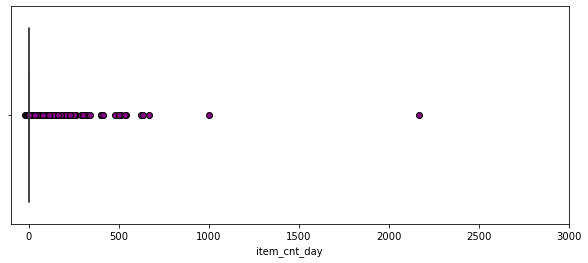

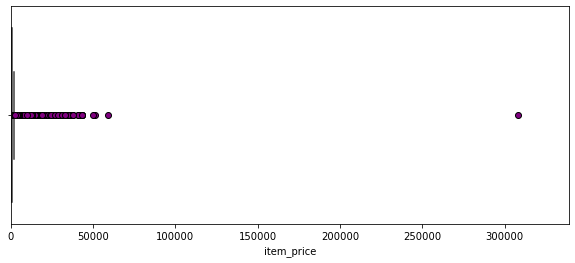

In [171]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=sales_train.item_cnt_day, flierprops=flierprops)

plt.figure(figsize=(10,4))
plt.xlim(sales_train.item_price.min(), sales_train.item_price.max()*1.1)
sns.boxplot(x=sales_train.item_price, flierprops=flierprops)

In [172]:
train = sales_train[(sales_train.item_price < 100000) & (sales_train.item_price > 0)] 
train = train[train.item_cnt_day < 1000]
train.loc[train.item_cnt_day < 1, "item_cnt_day"] = 0

## 2.2. Detect same shops

According to most of the kernels in kaggle, there were duplicated shop names but they had different shop_id.
So, I refered the kernels and changed the shop_id.

In [173]:
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57

train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58

train.loc[train.shop_id == 40, 'shop_id'] = 39
test.loc[test.shop_id == 40, 'shop_id'] = 39

train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

## 2.3. Simple train dataset

In [174]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

df = [] 
for block_num in train['date_block_num'].unique():
    current_shops = train.loc[train['date_block_num'] == block_num, 'shop_id'].unique()
    current_items = train.loc[train['date_block_num'] == block_num, 'item_id'].unique()
    df.append(np.array(list(product(*[current_shops, current_items, [block_num]])),dtype='int32'))

df = pd.DataFrame(np.vstack(df), columns = index_cols,dtype=np.int32)

#Add month sales
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

df = pd.merge(df, group, on=index_cols, how='left')
df['item_cnt_month'] = (df['item_cnt_month']
                                .fillna(0)
                                .clip(0,20)
                                .astype(np.float16))
df.head(5)

,shop_id,item_id,date_block_num,item_cnt_month
0,59,22154,0,1.0
1,59,2552,0,0.0
2,59,2554,0,0.0
3,59,2555,0,0.0
4,59,2564,0,0.0


## 2.4. Add test

Some shops and item didn't appear in the trainset. So concatenate df derived from train and test

In [175]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
df = pd.concat([df, test], ignore_index=True, sort=False, keys=index_cols)
df.fillna(0, inplace=True)

In [176]:
del current_items, current_shops

# 3) Feature engineering

## 3.1. **Shop features**

* Get city name for each shop from the shop name
* Refer some kernels to get city coords and country part (0-4) based on the map 

In [177]:
# Get city name for each shop from the shop name 
shops['city'] = shops['shop_name'].apply(lambda x: x.split()[0].lower())
shops.loc[shops.city == '!якутск', 'city'] = 'якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])

# Refer some kernels to get city coords and country part (0-4) based on the map
coords = dict()
coords['якутск'] = (62.028098, 129.732555, 4)
coords['адыгея'] = (44.609764, 40.100516, 3)
coords['балашиха'] = (55.8094500, 37.9580600, 1)
coords['волжский'] = (53.4305800, 50.1190000, 3)
coords['вологда'] = (59.2239000, 39.8839800, 2)
coords['воронеж'] = (51.6720400, 39.1843000, 3)
coords['выездная'] = (0, 0, 0)
coords['жуковский'] = (55.5952800, 38.1202800, 1)
coords['интернет-магазин'] = (0, 0, 0)
coords['казань'] = (55.7887400, 49.1221400, 4)
coords['калуга'] = (54.5293000, 36.2754200, 4)
coords['коломна'] = (55.0794400, 38.7783300, 4)
coords['красноярск'] = (56.0183900, 92.8671700, 4)
coords['курск'] = (51.7373300, 36.1873500, 3)
coords['москва'] = (55.7522200, 37.6155600, 1)
coords['мытищи'] = (55.9116300, 37.7307600, 1)
coords['н.новгород'] = (56.3286700, 44.0020500, 4)
coords['новосибирск'] = (55.0415000, 82.9346000, 4)
coords['омск'] = (54.9924400, 73.3685900, 4)
coords['ростовнадону'] = (47.2313500, 39.7232800, 3)
coords['спб'] = (59.9386300, 30.3141300, 2)
coords['самара'] = (53.2000700, 50.1500000, 4)
coords['сергиев'] = (56.3000000, 38.1333300, 4)
coords['сургут'] = (61.2500000, 73.4166700, 4)
coords['томск'] = (56.4977100, 84.9743700, 4)
coords['тюмень'] = (57.1522200, 65.5272200, 4)
coords['уфа'] = (54.7430600, 55.9677900, 4)
coords['химки'] = (55.8970400, 37.4296900, 1)
coords['цифровой'] = (0, 0, 0)
coords['чехов'] = (55.1477000, 37.4772800, 4)
coords['ярославль'] = (57.6298700, 39.8736800, 2) 

shops['city_coord_1'] = shops['city'].apply(lambda x: coords[x][0])
shops['city_coord_2'] = shops['city'].apply(lambda x: coords[x][1])
shops['country_part'] = shops['city'].apply(lambda x: coords[x][2])

shops = shops[['shop_id', 'city_code', 'city_coord_1', 'city_coord_2', 'country_part']]

## 3.2. **Item features**

* Get item category from the name of item_category_name. I use the first part of the name.
* Change some of the names to more common item category.

In [178]:
map_dict = {
            'Чистые носители (штучные)': 'Чистые носители',
            'Чистые носители (шпиль)' : 'Чистые носители',
            'PC ': 'Аксессуары',
            'Служебные': 'Служебные '
            }
items = pd.merge(items, item_categories, on='item_category_id')

# Get item category from the name of item_category_name. I use the first part of the name.
items['item_category'] = items['item_category_name'].apply(lambda x: x.split('-')[0])
items['item_category'] = items['item_category'].apply(lambda x: map_dict[x] if x in map_dict.keys() else x)
items['item_category_common'] = LabelEncoder().fit_transform(items['item_category'])

# Change some of the name to more common item category.
items['item_category_code'] = LabelEncoder().fit_transform(items['item_category_name'])
items = items[['item_id', 'item_category_common', 'item_category_code']]

In [179]:
df = pd.merge(df, shops, on=['shop_id'], how='left')
df = pd.merge(df, items, on=['item_id'], how='left')

In [180]:
df.shape

(11056277, 11)

## 3.3. **Date features**

* Get the frequency of weekend purchases : Weekends count (4 or 5)
* Number of days in a month

In [181]:
def count_days(date_block_num):
    year = 2013 + date_block_num // 12
    month = 1 + date_block_num % 12
    weeknd_count = len([1 for i in calendar.monthcalendar(year, month) if i[6] != 0])
    days_in_month = calendar.monthrange(year, month)[1]
    return weeknd_count, days_in_month, month

map_dict = {i: count_days(i) for i in range(35)}

df['weeknd_count'] = df['date_block_num'].apply(lambda x: map_dict[x][0])
df['days_in_month'] = df['date_block_num'].apply(lambda x: map_dict[x][1])

## 3.4. **Interaction features**

* Item is new
* Item was bought in this shop before

In [182]:
first_item_block = df.groupby(['item_id'])['date_block_num'].min().reset_index()
first_item_block['item_first_interaction'] = 1

first_shop_item_buy_block = df[df['date_block_num'] > 0].groupby(['shop_id', 'item_id'])['date_block_num'].min().reset_index()
first_shop_item_buy_block['first_date_block_num'] = first_shop_item_buy_block['date_block_num']

In [183]:
df = pd.merge(df, first_item_block[['item_id', 'date_block_num', 'item_first_interaction']], on=['item_id', 'date_block_num'], how='left')
df = pd.merge(df, first_shop_item_buy_block[['item_id', 'shop_id', 'first_date_block_num']], on=['item_id', 'shop_id'], how='left')

df['first_date_block_num'].fillna(100, inplace=True)
df['shop_item_sold_before'] = (df['first_date_block_num'] < df['date_block_num']).astype('int8')
df.drop(['first_date_block_num'], axis=1, inplace=True)

df['item_first_interaction'].fillna(0, inplace=True)
df['shop_item_sold_before'].fillna(0, inplace=True)
 
df['item_first_interaction'] = df['item_first_interaction'].astype('int8')  
df['shop_item_sold_before'] = df['shop_item_sold_before'].astype('int8') 

In [184]:
del first_item_block, first_shop_item_buy_block

## 3.5. **lag features**
### 3.5.1. Basic lag features

In [185]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        df[col+'_lag_'+str(i)] = df[col+'_lag_'+str(i)].astype('float16')
    return df

Add sales lags for last 3 months


In [186]:
ts = time.time()
df = lag_feature(df, [1, 2, 3], 'item_cnt_month')
time.time() - ts

18.94831895828247

In [187]:
df.shape

(11056277, 18)

Add avg shop/item price for last 3 months

In [188]:
ts = time.time()
index_cols = ['shop_id', 'item_id', 'date_block_num']
group = train.groupby(index_cols)['item_price'].mean().reset_index().rename(columns={"item_price": "avg_shop_price"}, errors="raise")
df = pd.merge(df, group, on=index_cols, how='left')

df['avg_shop_price'] = (df['avg_shop_price']
                                .fillna(0)
                                .astype(np.float16))

index_cols = ['item_id', 'date_block_num']
group = train.groupby(['date_block_num','item_id'])['item_price'].mean().reset_index().rename(columns={"item_price": "avg_item_price"}, errors="raise")
df = pd.merge(df, group, on=index_cols, how='left')

df['avg_item_price'] = (df['avg_item_price']
                                .fillna(0)
                                .astype(np.float16))

df['item_shop_price_avg'] = (df['avg_shop_price'] - df['avg_item_price']) / df['avg_item_price']
df['item_shop_price_avg'].fillna(0, inplace=True)

df = lag_feature(df, [1, 2, 3], 'item_shop_price_avg')
df.drop(['avg_shop_price', 'avg_item_price','item_shop_price_avg'], axis=1, inplace=True)
time.time() - ts

32.786585569381714

In [189]:
df.shape

(11056277, 21)

### 3.5.2 **Target encoding**

Add target encoding for items for last 3 months 

In [190]:
ts = time.time()
item_id_target_mean = df.groupby(['date_block_num','item_id'])['item_cnt_month'].mean().reset_index().rename(columns={"item_cnt_month": "item_target_enc"}, errors="raise")
df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_id'], how='left')

df['item_target_enc'] = (df['item_target_enc']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3], 'item_target_enc')
df.drop(['item_target_enc'], axis=1, inplace=True)
time.time() - ts

28.499770164489746

Add target encoding for item/city for last 3 months 


In [191]:
ts = time.time()
item_id_target_mean = df.groupby(['date_block_num','item_id', 'city_code'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "item_loc_target_enc"}, errors="raise")
df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_id', 'city_code'], how='left')

df['item_loc_target_enc'] = (df['item_loc_target_enc']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3], 'item_loc_target_enc')
df.drop(['item_loc_target_enc'], axis=1, inplace=True)
time.time() - ts

34.80991721153259

Add target encoding for item/shop for last 3 months 

In [192]:
ts = time.time()
item_id_target_mean = df.groupby(['date_block_num','item_id', 'shop_id'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "item_shop_target_enc"}, errors="raise")

df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_id', 'shop_id'], how='left')

df['item_shop_target_enc'] = (df['item_shop_target_enc']
                                .fillna(0)
                                .astype(np.float16))
                                
df = lag_feature(df, [1, 2, 3], 'item_shop_target_enc')
df.drop(['item_shop_target_enc'], axis=1, inplace=True)
time.time() - ts

36.5771644115448

### 3.5.3 Extra interaction features

For new items add avg category sales for last 3 months


In [193]:
ts = time.time()
item_id_target_mean = df[df['item_first_interaction'] == 1].groupby(['date_block_num','item_category_code'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "new_item_cat_avg"}, errors="raise")

df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_category_code'], how='left')

df['new_item_cat_avg'] = (df['new_item_cat_avg']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3], 'new_item_cat_avg')
df.drop(['new_item_cat_avg'], axis=1, inplace=True)
time.time() - ts

28.66535782814026

For new items add avg category sales in a separate store for last 3 months


In [194]:
item_id_target_mean = df[df['item_first_interaction'] == 1].groupby(['date_block_num','item_category_code', 'shop_id'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "new_item_shop_cat_avg"}, errors="raise")

df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_category_code', 'shop_id'], how='left')

df['new_item_shop_cat_avg'] = (df['new_item_shop_cat_avg']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3], 'new_item_shop_cat_avg')
df.drop(['new_item_shop_cat_avg'], axis=1, inplace=True)

Add sales for the last three months for similar item (item with id = item_id - 1;
kinda tricky feature, but increased the metric significantly)

In [195]:
def lag_feature_adv(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)+'_adv']
        shifted['date_block_num'] += i
        shifted['item_id'] -= 1
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        df[col+'_lag_'+str(i)+'_adv'] = df[col+'_lag_'+str(i)+'_adv'].astype('float16')
    return df

ts = time.time()
df = lag_feature_adv(df, [1, 2, 3], 'item_cnt_month')
time.time() - ts

24.119506359100342

Concatenate df with the extra information: shops, items, item_categories

In [196]:
df.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_cnt_month', 'ID',
       'city_code', 'city_coord_1', 'city_coord_2', 'country_part',
       'item_category_common', 'item_category_code', 'weeknd_count',
       'days_in_month', 'item_first_interaction', 'shop_item_sold_before',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_shop_price_avg_lag_1', 'item_shop_price_avg_lag_2',
       'item_shop_price_avg_lag_3', 'item_target_enc_lag_1',
       'item_target_enc_lag_2', 'item_target_enc_lag_3',
       'item_loc_target_enc_lag_1', 'item_loc_target_enc_lag_2',
       'item_loc_target_enc_lag_3', 'item_shop_target_enc_lag_1',
       'item_shop_target_enc_lag_2', 'item_shop_target_enc_lag_3',
       'new_item_cat_avg_lag_1', 'new_item_cat_avg_lag_2',
       'new_item_cat_avg_lag_3', 'new_item_shop_cat_avg_lag_1',
       'new_item_shop_cat_avg_lag_2', 'new_item_shop_cat_avg_lag_3',
       'item_cnt_month_lag_1_adv', 'item_cnt_month_lag_2_adv',
  

In [197]:
#Save dataset
df.drop(['ID'], axis=1, inplace=True, errors='ignore')
df.to_pickle('lgbm_df2.pkl')

In [198]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11056277 entries, 0 to 11056276
Data columns (total 38 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   shop_id                      int32  
 1   item_id                      int32  
 2   date_block_num               int32  
 3   item_cnt_month               float16
 4   city_code                    int32  
 5   city_coord_1                 float64
 6   city_coord_2                 float64
 7   country_part                 int64  
 8   item_category_common         int32  
 9   item_category_code           int32  
 10  weeknd_count                 int64  
 11  days_in_month                int64  
 12  item_first_interaction       int8   
 13  shop_item_sold_before        int8   
 14  item_cnt_month_lag_1         float16
 15  item_cnt_month_lag_2         float16
 16  item_cnt_month_lag_3         float16
 17  item_shop_price_avg_lag_1    float16
 18  item_shop_price_avg_lag_2    float16
 19

# 4) Train model

import time
import pandas as pd
import numpy as np
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import calendar
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
input_dir = "../data/input/"
output_dir = "../data/output/"

df = pd.read_pickle('lgbm_df2.pkl')
df.info()

Remove data for the first three months.
Through several experiments, I found that dropping the first three months improves the results.

In [199]:
df.fillna(0, inplace=True)
df = df[(df['date_block_num'] > 3)]
df.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_code,city_coord_1,city_coord_2,country_part,item_category_common,item_category_code,...,item_shop_target_enc_lag_3,new_item_cat_avg_lag_1,new_item_cat_avg_lag_2,new_item_cat_avg_lag_3,new_item_shop_cat_avg_lag_1,new_item_shop_cat_avg_lag_2,new_item_shop_cat_avg_lag_3,item_cnt_month_lag_1_adv,item_cnt_month_lag_2_adv,item_cnt_month_lag_3_adv
1497465,59,22114,4,1.0,30,57.62987,39.87368,2,11,40,...,0.0,0.986816,0.000000,0.000000,0.643066,0.000000,0.000000,0.0,0.0,0.0
1497466,59,20239,4,0.0,30,57.62987,39.87368,2,11,40,...,0.0,0.986816,0.000000,0.000000,0.643066,0.000000,0.000000,0.0,0.0,0.0
1497467,59,20238,4,1.0,30,57.62987,39.87368,2,11,40,...,0.0,0.986816,0.643066,0.518066,0.643066,0.411133,0.383301,0.0,0.0,0.0
1497468,59,20785,4,0.0,30,57.62987,39.87368,2,14,72,...,0.0,0.057465,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1497469,59,20783,4,0.0,30,57.62987,39.87368,2,14,72,...,0.0,0.057465,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [200]:
X_train = df[df.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = df[df.date_block_num < 33]['item_cnt_month']
X_valid = df[df.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = df[df.date_block_num == 33]['item_cnt_month']
X_test = df[df.date_block_num == 34].drop(['item_cnt_month'], axis=1)

Lightgbm got the best performance. XGB and Catboot didn't perform well.

In [201]:
feature_name = X_train.columns.tolist()

params = {
    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 127,
    'bagging_freq': 5,
    'learning_rate': 0.005,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'seed': 1,
    'verbose': 0
}

feature_name_indexes = [ 
                        'country_part', 
                        'item_category_common',
                        'item_category_code', 
                        'city_code',
]

lgb_train = lgb.Dataset(X_train[feature_name], Y_train)
lgb_eval = lgb.Dataset(X_valid[feature_name], Y_valid, reference=lgb_train)

evals_result = {}
gbm = lgb.train(
        params, 
        lgb_train,
        num_boost_round=3000,
        valid_sets=(lgb_train, lgb_eval), 
        feature_name = feature_name,
        categorical_feature = feature_name_indexes,
        verbose_eval=5, 
        evals_result = evals_result,
        early_stopping_rounds = 100)

C:\Users\user\anaconda3\envs\tensor\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['city_code', 'country_part', 'item_category_code', 'item_category_common']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.452354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


C:\Users\user\anaconda3\envs\tensor\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\user\anaconda3\envs\tensor\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[5]	training's rmse: 1.20859	valid_1's rmse: 1.12815
[10]	training's rmse: 1.19584	valid_1's rmse: 1.1181
[15]	training's rmse: 1.18359	valid_1's rmse: 1.10858
[20]	training's rmse: 1.17153	valid_1's rmse: 1.09932
[25]	training's rmse: 1.16023	valid_1's rmse: 1.09053
[30]	training's rmse: 1.14939	valid_1's rmse: 1.08239
[35]	training's rmse: 1.13895	valid_1's rmse: 1.07466
[40]	training's rmse: 1.12866	valid_1's rmse: 1.06677
[45]	training's rmse: 1.1187	valid_1's rmse: 1.05921
[50]	training's rmse: 1.10968	valid_1's rmse: 1.05289
[55]	training's rmse: 1.10045	valid_1's rmse: 1.04626
[60]	training's rmse: 1.09183	valid_1's rmse: 1.0398
[65]	training's rmse: 1.08366	valid_1's rmse: 1.034
[70]	training's rmse: 1.07566	valid_1's rmse: 1.02846
[75]	training's rmse: 1.06795	valid_1's rmse: 1.02271
[80]	training's rmse: 1.06054	valid_1's rmse: 1.01748
[85]	training's rmse: 1.0534	valid_1's rmse: 1.01245
[90]	training's rmse: 1.046

lgb.plot_importance(
    gbm, 
    max_num_features=50, 
    importance_type='gain', 
    figsize=(12,8));

In [204]:
test = pd.read_csv(os.path.join(input_dir,'test.csv'))
Y_test = gbm.predict(X_test[feature_name]).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('gbm_submission1120_3months.csv', index=False)

In [205]:
submission.head(3)

,ID,item_cnt_month
0,0,0.303116
1,1,0.338234
2,2,0.782433


# 5) Post-process

Sales are highly affected by social events. Therefore, it is not easy to forecast future sales just using historical data. Understanding the social events such as new games released,  new album released, or COVID-19(not related to the current topic but it unprecedently made people buy the masks a lot in Summer), is crucial for predicting future sales.

In [206]:
item = pd.read_csv("../data/input/items.csv")
test = pd.read_csv("../data/input/test.csv")

In [207]:
submission = pd.read_csv('gbm_submission1120_3months.csv')

In [208]:
tmp = test.merge(shops,on="shop_id",how='left').merge(item,on='item_id',how='left')

In [209]:
tmp.head(1)

,ID,shop_id,item_id,city_code,city_coord_1,city_coord_2,country_part,item_name,item_category_id
0,0,5,5037,3,59.2239,39.88398,2,"NHL 15 [PS3, русские субтитры]",19


## 5.1. Games

In November 2015, PS4 released new game series, Call of Duty, Fallout4, and Star Wars: Battlefront. These games were so popular that the sales of the games had higher values in November than others, and the phenomenon can't be explained by using historical data.

In [210]:
games = tmp[tmp.item_name.str.contains("Call of Duty|Fallout4|Star Wars: Battlefront")].ID

In [211]:
submission.loc[submission.ID.isin(games),"item_cnt_month"] *= 1.3

## 6.2. One Direction album

In addition, One Direction, an English-Irish pop boy band, which is famous in Russia(according to one of the kernels in Kaggle) released a new album in November 2015. Likewise the PS4 games, the music album is expected to be sold a lot at that time. The sales of the newly released album are not easy to predict just using historical data that is not directly related to.

In [212]:
submission.loc[tmp.item_name.str.contains("ONE DIRECTION"),"item_cnt_month"] *= 4.8

In [213]:
submission.to_csv('gbm_submission1120_3months_games130_OD480.csv', index=False)